<a href="https://colab.research.google.com/github/kidp330/huffman-encoder/blob/main/model_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import graphviz
import numpy as np
from queue import PriorityQueue
from collections import Counter
 
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
matplotlib.rcParams.update({'font.size': 14})
 
import nltk
from nltk.corpus import gutenberg
nltk.download('gutenberg')
 
import random
random.seed(325789)

[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Unzipping corpora/gutenberg.zip.


In [2]:
class hmnode:
  def __init__(self, frequency: int, label: str = ''):
    self.frequency = frequency
    self.label = label
    self.children = None
 
  def __str__(self):
    non_displayable = {'\n': 'nl', '\r': 'cr', ' ': 'sp'}
    return non_displayable[self.label] if self.label in non_displayable else self.label
 
  def __lt__(self, other):
    return self.frequency < other.frequency
 
  def __eq__(self, other):
    return self.label == other.label

In [3]:
class hmtree:
  def __init__(self, PD: dict):
    PQ = PriorityQueue()
    for label, p in PD.items():
      PQ.put(hmnode(p, label))
    
    while PQ.qsize() != 1:
      u1, u2 = PQ.get(), PQ.get()
      v = hmnode(frequency = u1.frequency + u2.frequency)
      v.children = (u1, u2)
      PQ.put(v)
 
    self.root = PQ.get()
    self.construct_coding()
 

  def _descend(self, v: hmnode, path: str):
    if v.label != '':
      self.coding[v.label] = path
      return
    self._descend(v.children[0], path+'0')
    self._descend(v.children[1], path+'1')
 
  def construct_coding(self):
    self.coding = {}
    self._descend(self.root, '')
  

  def decode(self, text: str) -> str:
    decoded_text = ''
    v = self.root
    for c in text:
      c = int(c)
      v = v.children[c]
      if v.label != '':
        decoded_text += v.label
        v = self.root
    return decoded_text
 
  def encode(self, text: str) -> str:
    return ''.join(self.coding[c] for c in text)


  def _frequencies(self, v: hmnode):
    if v.children is None:
      return np.array([v.frequency])
    return np.concatenate((self._frequencies(v.children[0]),
                           self._frequencies(v.children[1]),
                           np.array([v.frequency])))
    
  def frequencies(self):
    return self._frequencies(self.root)

  def _render(self, GT: graphviz.Graph, v: hmnode):
    GT.node(str(id(v)), label=str(v), shape='rectangle', fontsize='28.0', fixedsize='true', style='filled', colorscheme='bugn9', fillcolor=str(round(7.6+np.log10(v.frequency))))
    if v.label != '':
      return
    for i in range(2):
      self._render(GT, v.children[i])
      GT.edge(str(id(v)), str(id(v.children[i])))
  
  def render(self):
    GT = graphviz.Graph()
    self._render(GT, self.root)
    return GT
  

In [4]:
class hmtree_opt(hmtree):
  def __init__(self, PD: dict):
    hmtree.__init__(self, PD)
    self.enc_len = dict((key, len(val)) for key, val in self.coding.items())
  def encoding_length(self, text: str) -> int:
    C = Counter(text)
    return sum(self.enc_len[c]*C[c] for c in C)

In [5]:
gutenberg_fq = Counter(gutenberg.raw())

In [6]:
# for key in [key for key, val in gutenberg_fq.items() if val <= 5]:
#   del gutenberg_fq[key]

In [7]:
non_displayable = {'\n': '\\n', '\r': ' \\r', ' ': '<>', '\x1a': ' '}
items_mod = sorted([(non_displayable[key], val) if key in non_displayable else (key, val) for key, val in gutenberg_fq.items()])
keys_mod, values_mod = map(list, zip(*items_mod))

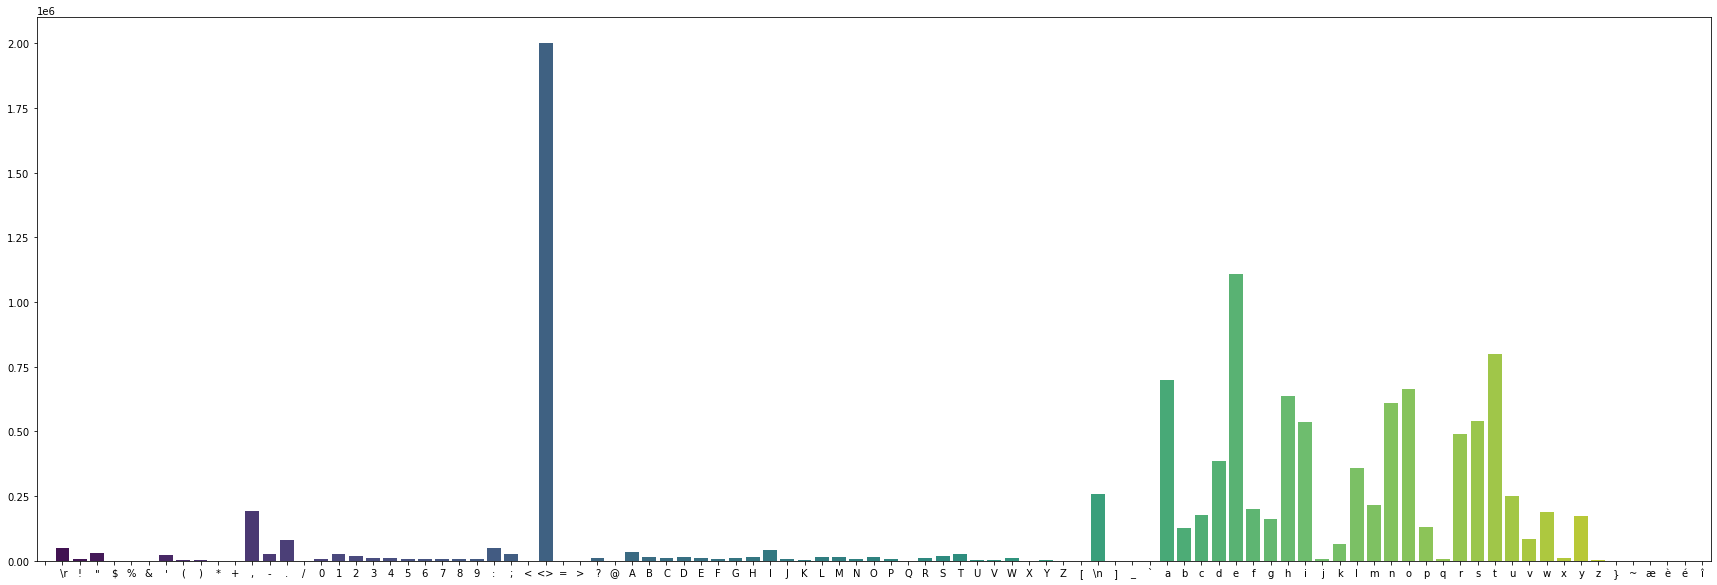

In [8]:
fig, ax = plt.subplots(figsize=(30, 10))
sns.barplot(x=keys_mod, y=values_mod, ax=ax, palette='viridis')
plt.show()

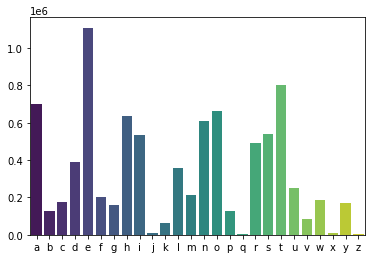

In [9]:
alpha = slice(keys_mod.index('a'), keys_mod.index('z')+1)
sns.barplot(x=keys_mod[alpha], y=values_mod[alpha], palette='viridis')
plt.show()

In [10]:
def FQ_to_PD(FQ: dict):
  omega = sum(FQ.values())
  return {key: val/omega for key, val in FQ.items()}

def random_string(length: int, alphabet: list):
  return ''.join([random.choice(alphabet) for i in range(length)])

In [11]:
gutenberg_tree = hmtree(FQ_to_PD(gutenberg_fq))
gbplus = hmtree_opt(FQ_to_PD(gutenberg_fq))

In [ ]:
# Check correctness

for i in range(10000):
  S = random_string(random.randint(0,1000), list(gutenberg_fq.keys()))
  encoded = gutenberg_tree.encode(S)
  decoded = gutenberg_tree.decode(encoded)
  if S != decoded:
    print(S)

In [12]:
T = gutenberg_tree.render()
T.graph_attr['size'] = '10'
T

1. Resize Tree window **Done**
2. Figure out how to display pvalues, also for intermediate nodes
    Perhaps color coding, shading by frequency could add vibrancy **Done**
3. Make a destructor for hmnode and hmtree
4. Learn how to do comment descriptions to annotate hm classes
5. Efficiency comparisons:
  - Hand-picked short english sentences, written or excerpts from gb
  - Randomly generated strings, showcasing worse results
  - Coding text through tree constructed from same text, difference in efficieny compared to gbtree
  - Compression ratios for different texts from gb and other sources

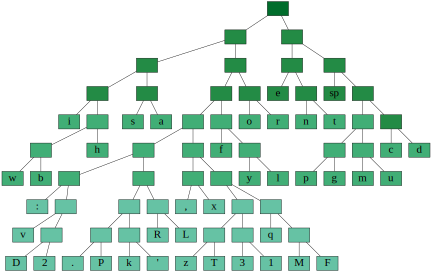

In [13]:
the_plan = ['Resize Tree window',
            'Figure out how to display pvalues, also for intermediate nodes. Perhaps color coding, shading by frequency could add vibrancy',
            'Make a destructor for hmnode and hmtree',
            'Learn how to do comment descriptions to annotate hm classes',
            'Display efficiency comparisons for 1:random text, 2:proper english sentences, 3:gutenberg excerpts',
            'Research difference between efficiency in trees constructed from text\'s own frequency data and from the gutenberg tree',
            'Later: design a binary file format efficient enough to store its tree as a header and then the coded text']

example_fq = Counter(''.join(the_plan))
example_tree = hmtree(FQ_to_PD(example_fq))
T = example_tree.render()
T.graph_attr['size'] = '6'
T

Ratios of Huffman tree encoding lengths to ASCII lengths, for trees constructed on the Gutenberg corpus and specifically for this set of sentences

In [14]:
for i, s in enumerate(the_plan):
  ex_compression = len(example_tree.encode(s))/(8*len(s))
  ex_compression = round(ex_compression*100, ndigits=2)
  gb_compression = len(gutenberg_tree.encode(s))/(8*len(s))
  gb_compression = round(gb_compression*100, ndigits=2)
  print("Text #{}:".format(i+1))
  print("Gutenberg tree: {}%".format(gb_compression))
  print("Example tree: {}%".format(ex_compression))
  print()


Text #1:
Gutenberg tree: 63.89%
Example tree: 59.03%

Text #2:
Gutenberg tree: 59.0%
Example tree: 57.2%

Text #3:
Gutenberg tree: 54.81%
Example tree: 53.85%

Text #4:
Gutenberg tree: 53.39%
Example tree: 51.91%

Text #5:
Gutenberg tree: 61.86%
Example tree: 57.78%

Text #6:
Gutenberg tree: 56.36%
Example tree: 52.65%

Text #7:
Gutenberg tree: 52.98%
Example tree: 50.6%



Despite a small improvement from manually constructing a tree, both encoders manage to cut the text length in up to a half for small examples. This might not be the case for randomly generated text.

In [15]:
random_corpus = random_string(length=10000000, alphabet=list(gutenberg_fq.keys()))

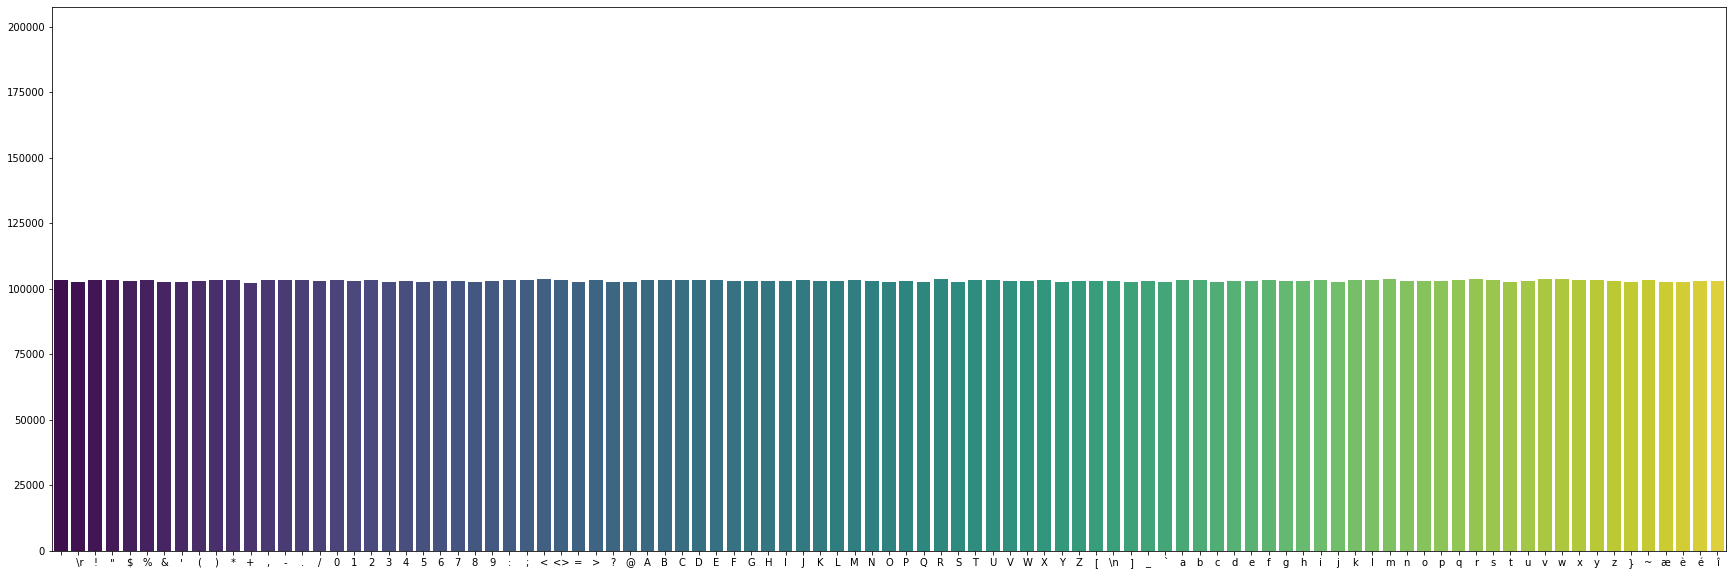

In [16]:
random_fq = Counter(random_corpus)
items_mod = sorted([(non_displayable[key], val) if key in non_displayable else (key, val) for key, val in random_fq.items()])
keys_mod, values_mod = map(list, zip(*items_mod))

fig, ax = plt.subplots(figsize=(30, 10))
ax.set_ylim(top=max(values_mod)*2)
sns.barplot(x=keys_mod, y=values_mod, palette='viridis', ax=ax)
plt.show()

In [17]:
random_fq = Counter(random_corpus)
random_tree = hmtree(FQ_to_PD(random_fq))
T = random_tree.render()
T.graph_attr['size'] = '11'
T

Since the alphabet is equally distributed, it makes sense for the Huffman tree to be constructed as a balanced binary tree. \
One could interpret ASCII as a Huffman tree, isomorphic to a perfect binary tree with height = 8

In [18]:
# let sample length be a mean of the lengths of example texts
sample_length = sum(map(len, the_plan))//len(the_plan)

random_samples = []
for i in range(len(the_plan)):
  start = random.randint(0, len(random_corpus)-sample_length)
  random_samples.append(random_corpus[start:start+sample_length])

print("Random example: {}\n".format(random_samples[0]))

X`[~8tAQl"fM(tQiK;
E1UmQ*



In [19]:
for i, s in enumerate(random_samples):
  gb_compression = len(gutenberg_tree.encode(s))/(8*len(s))
  rn_compression = len(random_tree.encode(s))/(8*len(s))
  print("Text #{}:".format(i+1))
  print("Gutenberg tree: {}%".format(round(gb_compression*100, ndigits=2)))
  print("Random tree: {}%".format(round(rn_compression*100, ndigits=2)))
  print()

Text #1:
Gutenberg tree: 136.41%
Random tree: 83.28%

Text #2:
Gutenberg tree: 134.69%
Random tree: 82.97%

Text #3:
Gutenberg tree: 149.06%
Random tree: 83.59%

Text #4:
Gutenberg tree: 134.84%
Random tree: 84.22%

Text #5:
Gutenberg tree: 138.75%
Random tree: 82.19%

Text #6:
Gutenberg tree: 143.12%
Random tree: 82.34%

Text #7:
Gutenberg tree: 131.72%
Random tree: 82.5%



For random sentences of similar length, the Gutenberg tree performs worse than standard ASCII coding, while the tree constructed from the corpus itself offers about a 15% cut-off in length.

It's time to test the trees on all separate Gutenberg texts and compare results

In [20]:
for text_id in gutenberg.fileids():
  f = gutenberg.open(text_id)
  text = f.read()
  gb_len = len(gutenberg_tree.encode(text))
  con_len = len(hmtree(FQ_to_PD(Counter(text))).encode(text))
  gb_efficiency = gb_len/(8*len(text))
  constructed_efficiency = con_len/(8*len(text))
  f.close()
  print("{}: ".format(text_id))
  print("Gutenberg tree: {}%".format(round(gb_efficiency*100, ndigits=2)))
  print("Constructed tree: {}%".format(round(constructed_efficiency*100, ndigits=2)))
  print()

austen-emma.txt: 
Gutenberg tree: 57.27%
Constructed tree: 56.64%

austen-persuasion.txt: 
Gutenberg tree: 56.29%
Constructed tree: 55.78%

austen-sense.txt: 
Gutenberg tree: 56.67%
Constructed tree: 56.13%

bible-kjv.txt: 
Gutenberg tree: 57.7%
Constructed tree: 57.25%

blake-poems.txt: 
Gutenberg tree: 58.23%
Constructed tree: 57.46%

bryant-stories.txt: 
Gutenberg tree: 57.64%
Constructed tree: 56.94%

burgess-busterbrown.txt: 
Gutenberg tree: 58.49%
Constructed tree: 57.59%

carroll-alice.txt: 
Gutenberg tree: 58.29%
Constructed tree: 57.34%

chesterton-ball.txt: 
Gutenberg tree: 56.93%
Constructed tree: 56.41%

chesterton-brown.txt: 
Gutenberg tree: 56.44%
Constructed tree: 55.91%

chesterton-thursday.txt: 
Gutenberg tree: 56.88%
Constructed tree: 56.34%

edgeworth-parents.txt: 
Gutenberg tree: 58.39%
Constructed tree: 57.69%

melville-moby_dick.txt: 
Gutenberg tree: 57.82%
Constructed tree: 57.23%

milton-paradise.txt: 
Gutenberg tree: 56.98%
Constructed tree: 56.48%

shakespeare

Here the constructed trees provide little improvement in compression to the Gutenberg tree, which may be due to text similarity.

In [21]:
def length_distribution_optimized(corpus: str, encoders: list, sample_length: int = 100, no_of_samples: int = 10) -> list:
  for encoder in encoders:
    if not isinstance(encoder, hmtree_opt):
      raise TypeError("Encoder is not of type hmtree_opt")
  
  distr = [[]]*len(encoders)
  for i in range(no_of_samples):
    start = random.randint(0, len(corpus)-sample_length)
    for j, encoder in enumerate(encoders):
      distr[j].append(encoder.encoding_length(corpus[start:start+sample_length]))
  return distr

In [22]:
data=length_distribution_optimized(gutenberg.raw(), [gbplus], sample_length=1000, no_of_samples=10000000)

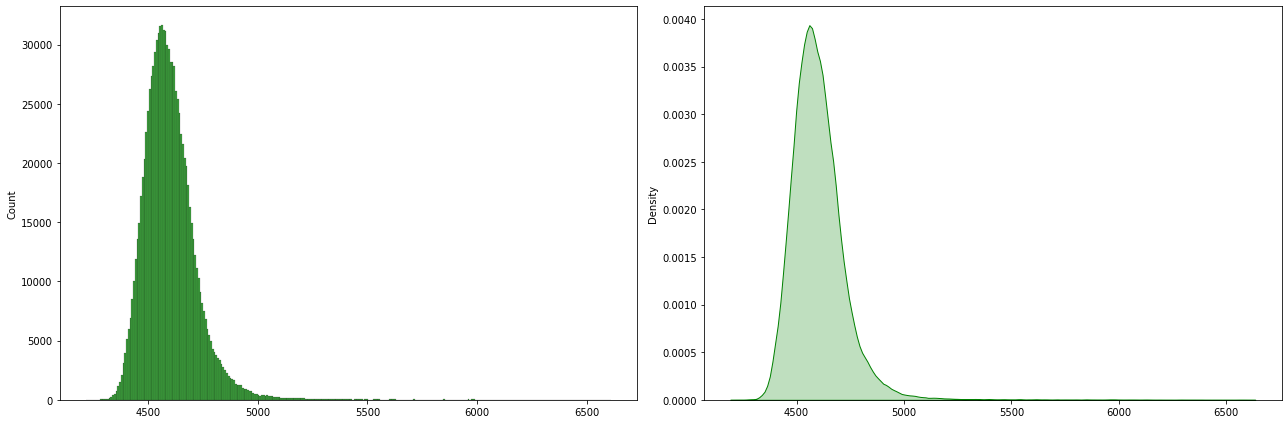

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(18, 6))
sns.histplot(data[0], color='green', bins=300, ax=axs[0])
sns.kdeplot(data[0], color='green', fill=True, ax=axs[1])
plt.tight_layout()
plt.show()